In [32]:
from moonlight import *
import os
os.environ['JAVA_HOME'] ="/usr/lib/jvm/java-1.8.0-openjdk-amd64"
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt 
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import os 
from sys import path
from copy import deepcopy
path.append("/home/maria/Documenti/Università/CPS") 
from utility import *
from simulation import *
import pickle

In [33]:
dir_path = "/home/maria/Documenti/Università/CPS"
dir_data = "/home/maria/Documenti/Università/CPS/Requirements"

In [34]:
actor_path = "/home/maria/Documenti/Università/CPS/slow_model"

In [35]:
#test of model with noise, with kalman filter and with the behaviors "reach goal " and "avoid obstacle"

In [36]:
#I saved the coordinates of one obstacle to test the property that the robot 
#must never get closer to the obstacle of a certain distance, so I'm using the coordinate of the obstacle in the 
#script, this because I'm not using a scalar mieasure of the distance but I'm calculating the distance in the script,
#in order to preserve the spatial structure of the problem 

In [37]:
obstacle_file = os.path.join(dir_path,"obstacle.pickle")

In [38]:
with open(obstacle_file,'rb') as f: 
    obstacle :State = pickle.load(f)

In [39]:
obstacle.x


17.17719188961165

In [40]:
obstacle.y

-16.66282030988458

In [41]:
state_space = []
state_space_2 = [] 
state_space_3 = []
target_space = []

In [42]:
num_ = 40

In [43]:
np.random.seed(71)


In [44]:
for i in range(num_ +2): 
    while True: 
        a = np.random.uniform(-40,40,2)
        b = np.random.uniform(0,90,3)
        
        spatial_state = State(a[0],a[1],np.radians(b[0]))
        if spatial_state.distance_form_state(obstacle)>8:
            
            tx = 2*obstacle.x-spatial_state.x + np.random.normal(0,0.2)
           # if tx>40 or tx<-40: 
               # break 
            ty = 2*obstacle.y-spatial_state.y +np.random.normal(0,0.2)
            
            target = State(tx,ty,np.radians(b[1]))
            if (tx<40 and tx>-40)and(ty<40 and ty>-40): 
                break
    state_space.append(spatial_state)
    state_space_2.append(deepcopy(spatial_state))
    state_space_3.append(deepcopy(spatial_state))                
    target_space.append(target)      
    

In [45]:
n_sim = 1200 
target = target_space[-1]

In [46]:
#simulation without noise
state_sp = deepcopy(state_space[-1])

In [47]:
x,y,theta,t,string,_,_= simulation(state_sp,target,algo=0,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=0.5,p_noise=0.1)

In [17]:
file_animation = os.path.join(dir_path,"animation.gif")

In [20]:
animation_plot(x,y,target.x,target.y,obstacle.x,obstacle.y,file_name=file_animation)

In [21]:
#simulation with model with noise and kalman filter with observation noise 0.5 and process noise 0.1 

In [48]:
x,y,theta,t,string,innovation,covariance= simulation(state_space[-1],target_space[-1],algo=2,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=0.5,p_noise=0.1)

In [49]:
string 

'arrived at episode272'

In [50]:
file_animation = os.path.join(dir_path,"animation_noise.gif")

In [51]:
animation_plot(x,y,target.x,target.y,obstacle.x,obstacle.y,file_name=file_animation)

In [52]:
#check if the kalman filter is working 

In [53]:
for i in range(len(covariance)): 
    covariance[i]=2*np.sqrt(covariance[i])

<ipython-input-53-d7c62e6dbb33>:2: RuntimeWarning: invalid value encountered in sqrt
  covariance[i]=2*np.sqrt(covariance[i])


In [54]:
innov_z = []
innov_y = [] 
innov_x = [] 
std_z = [] 
std_y= [] 
std_x = []
std_x_lower = []
std_y_lower = []
std_z_lower = []

In [55]:
for i in range(len(innovation)): 
    innov_x.append(innovation[i][0])
    std_x.append(covariance[i][0,0])
    std_x_lower.append(-covariance[i][0,0])
    innov_y.append(innovation[i][1])
    std_y.append(covariance[i][1,1])
    std_y_lower.append(-covariance[i][1,1])
    innov_z.append(innovation[i][2])
    std_z.append(covariance[i][2,2])
    std_z_lower.append(-covariance[i][2,2])

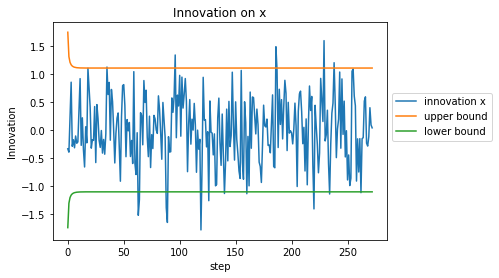

In [56]:
plt.plot(innov_x,label="innovation x")
plt.plot(std_x,label = "upper bound")
plt.plot(std_x_lower, label = "lower bound") 
plt.title("Innovation on x")
plt.xlabel("step")
plt.ylabel("Innovation")
plt.legend(bbox_to_anchor=(1.0,0.7))


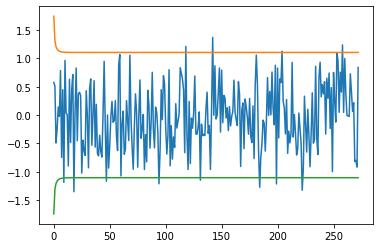

In [57]:
plt.plot(innov_y)
plt.plot(std_y)
plt.plot(std_y_lower) 

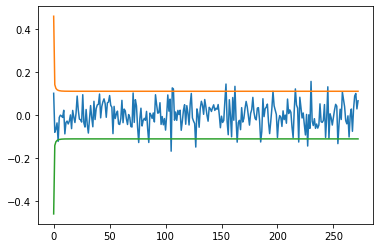

In [58]:
plt.plot(innov_z)
plt.plot(std_z)
plt.plot(std_z_lower) 

In [59]:
#VERIFICATION OF REQUIREMENTS 

#the quadratic distance of the robot to the obstacle must never be less or equal to 0.3 during all the simulation

In [60]:
script = """
signal { real x; real y;}
domain minmax; 
formula safety = {globally[0,120]((((x-17.17719)*(x-17.17719))+((y+16.66282)*(y+16.66282)))>0.3)};
"""

In [61]:
moonlightScript = ScriptLoader.loadFromText(script);
safetyMonitor = moonlightScript.getMonitor("safety"); 

In [62]:
ob_noise_ = 0.5
p_noise_ =0.05

In [63]:
robustness_kalman = [] 
robustness_only_noise = []
robustness_no_noise = []


In [64]:
#il seguente codice va eseguito solo una volta, se si ripete ricarivare la lista con gli stati 

In [65]:
for h in range(num_):
    state = state_space[h]
    state_1=deepcopy(state)
    state_2=deepcopy(state)
    target = target_space[h]
    #first verification with noise using a kalman filter 
    x,y,theta,t,string,innovation,covariance = simulation(state,target,algo=2,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
    xx = np.array(x)
    yy = np.array(y)
    signals = list(zip(xx,yy))
    safetyMonitorResult = safetyMonitor.monitor(t,signals)
    
   # print("robustness kalman filter ",safetyMonitorResult[0][1])
    robustness_kalman.append(round(safetyMonitorResult[0][1],3))
    x,y,theta,t,string,innovation,covariance = simulation(state_1,target,algo=1,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
    xx = np.array(x)
    yy = np.array(y)
    signals = list(zip(xx,yy))
    safetyMonitorResult = safetyMonitor.monitor(t,signals)
    #print("robustness only noise ",safetyMonitorResult[0][1])
    robustness_only_noise.append(round(safetyMonitorResult[0][1],3))
    
    x,y,theta,t,string,innovation,covariance = simulation(state_2,target,algo=0,sim=n_sim,obstacle=obstacle,path=actor_path)
    xx = np.array(x)
    yy = np.array(y)
    signals = list(zip(xx,yy))
    safetyMonitorResult = safetyMonitor.monitor(t,signals)
    #print("robustness no noise ",safetyMonitorResult[0][1])
    robustness_no_noise.append(round(safetyMonitorResult[0][1],3))
    

In [66]:

req_safety = os.path.join(dir_data, "req_safety.txt")


In [67]:
with open(req_safety,'w') as f: 
    f.write("Robustness of the model with process noise 0.05 and observation noise 0.5\n")
    f.write("kalman_rob\tonly_noise_rob\tno_noise_rob\n")  
    for i in range(num_):
        f.write(str(robustness_kalman[i])+"\t\t"+str(robustness_only_noise[i])+"\t\t"+str(robustness_no_noise[i])+"\n")
        
  
            
            

In [68]:
mean_kalman_r = np.mean(np.asarray(robustness_kalman))
mean_kalman_r


4.0116

In [69]:
mean_only_noise_r = np.mean(np.asarray(robustness_only_noise))
mean_only_noise_r

3.3534999999999995

In [70]:
mean_rob_no_noise = np.mean(np.asarray(robustness_no_noise))
mean_rob_no_noise

4.3142499999999995

In [71]:
#falsification of this property 
#I use the other list because the initial state of the old list is changed 

In [72]:
#firse I do falsification only respect to the observation noise  
ob_noise_=0.0
obse_noise = []
kalm_mean =[]
no_kalm_mean = []
min_k= []
min_n = []

flag_k = 1 
flag_n=1

In [73]:
for s in range(40):
    falsification_obs_kalman = [] 
    falsification_obs_only_noise = []
    list_ = deepcopy(state_space_2)
    ob_noise_ +=0.1
    for h in range(num_):
        state = list_[h]
        state_1=deepcopy(state)
        #state_2=deepcopy(state)
        target = target_space[h]
        #first verification with noise using a kalman filter 
        #ob_noise_ +=0.1
    
        x1,y1,theta,t1,string,innovation,covariance = simulation(state,target,algo=2,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)

        xx = np.array(x1)
        yy = np.array(y1)
        signals = list(zip(xx,yy))
        safetyMonitorResult_1 = safetyMonitor.monitor(t,signals)
        if flag_k==1: 
            if safetyMonitorResult_1[0][1]<0: 
                print("observation noise  model with kalman filter must be less then= ",ob_noise_)
                flag_k=0 
    
   # print("robustness kalman filter with ",ob_noise_," observation noise = ",safetyMonitorResult[0][1])
        falsification_obs_kalman.append(round(safetyMonitorResult_1[0][1],3))
        #obse_noise.append(round(ob_noise_,3))
        x,y,theta,t,string,innovation,covariance = simulation(state_1,target,algo=1,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
        xx = np.array(x)
        yy = np.array(y)
        signals = list(zip(xx,yy))
        safetyMonitorResult = safetyMonitor.monitor(t,signals)
        if flag_n==1: 
            if safetyMonitorResult[0][1]<0: 
                print("observation noise model without kalman filter must be less then = ",ob_noise_)
                flag_n=0 
    
   # print("robustness only noise with ",ob_noise_," observation_noise = ",safetyMonitorResult[0][1])
        falsification_obs_only_noise.append(round(safetyMonitorResult[0][1],3))
    obse_noise.append(round(ob_noise_,3))
    kalm_mean.append(np.mean(np.asarray(falsification_obs_kalman)))
    no_kalm_mean.append(np.mean(np.asarray(falsification_obs_only_noise)))
    min_k.append(min(falsification_obs_kalman))
    min_n.append(min(falsification_obs_only_noise))
    

observation noise model without kalman filter must be less then =  0.7
observation noise  model with kalman filter must be less then=  2.400000000000001


In [47]:
#animation_plot(x,y,target.x,target.y,obstacle.x,obstacle.y,file_name="animation_noise.gif")
#obse_noise 

In [74]:
file_2 = os.path.join(dir_data,"falsif_obs_noise_No_kalman.txt")

with open(file_2,'w') as f: 
    f.write("noise\t mean rob\t min rob\n")
    for i in range(len(obse_noise)):
        f.write(str(obse_noise[i])+"\t"+str(round(no_kalm_mean[i],3))+"\t\t"+str(min_n[i])+"\n")
        

In [75]:
file_1 = os.path.join(dir_data,"falsif_obs_noise_kalman.txt")

In [76]:
with open(file_1,'w') as f: 
    f.write("noise\t mean rob\t min rob\n")
    for i in range(len(obse_noise)):
        f.write(str(obse_noise[i])+"\t"+str(round(kalm_mean[i],3))+"\t\t"+str(min_k[i])+"\n")
        

In [77]:
#falsification varying both process and observation noise 

In [78]:
ob_noise_= 0.0
p_noise_ = 0.0 

In [79]:
obse_noise = []
process_noise = []

kalman_mean = []
only_noise_mean = []
flag_n = 1
flag_k = 1
min_k = []
min_noise = []

In [80]:
for s in range(40):
    falsification_noise_kalman = []
    falsification_noise_only_noise = []
    list_state = deepcopy(state_space_3)
    ob_noise_ +=0.1
    p_noise_+=0.01
    for h in range(num_-1):
        state = list_state[h]
        state_1=deepcopy(state)
    #state_2=deepcopy(state)
        target = target_space[h]
    #first verification with noise using a kalman filter 
    #ob_noise_ +=0.1
    #p_noise_+=0.01
        
        x1,y1,theta,t1,string,innovation,covariance = simulation(state,target,algo=2,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
        #print(string)
        xx = np.array(x1)
        yy = np.array(y1)
        signals = list(zip(xx,yy))
        safetyMonitorResult = safetyMonitor.monitor(t,signals)
        if flag_k==1:
            if(safetyMonitorResult[0][1])<0:
                print("Max noise model with kalman filter should be less then: observation noise = ",ob_noise_,"process noise = ",p_noise_)
                flag_k=0
        #print("robustness kalman filter with ",ob_noise_," observation noise = ",safetyMonitorResult[0][1])
        falsification_noise_kalman.append(round(safetyMonitorResult[0][1],3))
        #obse_noise.append(round(ob_noise_,3))
        
        x,y,theta,t,string,innovation,covariance = simulation(state_1,target,algo=1,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
        xx = np.array(x)
        yy = np.array(y)
        signals = list(zip(xx,yy))
        safetyMonitorResult = safetyMonitor.monitor(t,signals)
        if flag_n==1:
            if(safetyMonitorResult[0][1])<0:
                flag_n=0
                print("Max noise model without kalman filter should be less then : observation noise = ",ob_noise_,"process noise = ",p_noise_)
        #print(string)
        #print("robustness only noise with ",ob_noise_," observation_noise = ",safetyMonitorResult[0][1])
        falsification_noise_only_noise.append(round(safetyMonitorResult[0][1],3))
    obse_noise.append(round(ob_noise_,3))
    process_noise.append(round(p_noise_,3))
    #mean_k = 
    kalman_mean.append(np.mean(np.asarray(falsification_noise_kalman)))
    only_noise_mean.append(np.mean(np.asarray(falsification_noise_only_noise)))
    min_k.append(min(falsification_noise_kalman))
    min_noise.append(min(falsification_noise_only_noise))
    
    

Max noise model without kalman filter should be less then : observation noise =  0.8999999999999999 process noise =  0.09
Max noise model with kalman filter should be less then: observation noise =  1.0999999999999999 process noise =  0.10999999999999999


In [81]:
file_2 = os.path.join(dir_data,"falsif_both_noises_kalman.txt")

In [82]:
with open(file_2,'w') as f: 
    f.write("ob_noise\tpr_noise\t mean rob\ min_rob\n")
    for i in range(len(obse_noise)):
        f.write(str(obse_noise[i])+"\t\t"+str(process_noise[i])+"\t\t"+str(round(kalman_mean[i],3))+"\t\t"+str(min_k[i])+"\n")
        

In [83]:
len(obse_noise)

40

In [84]:
file_3 = os.path.join(dir_data,"falsif_both_noise_noKalman.txt")

In [85]:
with open(file_3,'w') as f: 
    f.write("ob_noise\tpr_noise\tmean rob\ min_rob\n")
    for i in range(len(obse_noise)):
        f.write(str(obse_noise[i])+"\t\t"+str(process_noise[i])+"\t\t"+str(round(only_noise_mean[i],3))+"\t\t"+str(min_noise[i])+"\n")
        

In [86]:
np.random.seed(89)
new_state = []
new_obstacle = [] 

In [87]:
#property that the robot always reach the target within 800 steps(so befor time 80) and then stays there, when there is no obstacle 
#for the same reason as before, I've saved the target coordinate and vary the coordinate of the initial state 
#of the robot 

In [88]:
with open("target.pickle",'rb') as f: 
    target :State = pickle.load(f)

In [89]:
for i in range(num_ +1): 
    
    while True: 
    
        a = np.random.uniform(-40,40,2)
        b = np.random.uniform(0,90,3)
        spatial_state = State(a[0],a[1],np.radians(b[0]))        
        if spatial_state.distance_form_state(target)>30:
            
            ox = (spatial_state.x +target.x)/2 
            oy = (spatial_state.y +target.y)/2 
            obstacle_ = State(ox,oy,np.radians(b[1]))
            new_state.append(spatial_state)
            new_obstacle.append(obstacle_)
            break
            

In [90]:
new_state_2 = deepcopy(new_state)

In [91]:


target.x 


31.015813915122948

In [92]:
target.y

-13.868786212911786

In [93]:
script_reach = """
signal { real x; real y;}
domain minmax; 
formula reach_t = {globally[80,120]((((x-31.01581)*(x-31.01581))+((y+13.86878)*(y+13.86878)))<0.3)};
"""

In [94]:
moonlightScript = ScriptLoader.loadFromText(script_reach);
reachMonitor = moonlightScript.getMonitor("reach_t"); 

In [95]:
ob_noise_ = 0.5

In [96]:
p_noise_ = 0.05

In [97]:
robustness_kalman = [] 
robustness_only_noise=[]

In [98]:
for h in range(num_):
    state = new_state[h]
    state_1 = deepcopy(state)
    #state_1=deepcopy(state)
    #state_2=deepcopy(state)
    #target = target_space[h]
    #first verification with noise using a kalman filter 
    x,y,theta,t,string,innovation,covariance = simulation(state,target,algo=2,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
    xx = np.array(x)
    yy = np.array(y)
    signals = list(zip(xx,yy))
    reachMonitorResult_1 = reachMonitor.monitor(t,signals)
    
    #print("robustness kalman filter ",reachMonitorResult_1[0][1])
    robustness_kalman.append(round(reachMonitorResult_1[0][1],3))
    
    x,y,theta,t,string,innovation,covariance = simulation(state_1,target,algo=1,sim=n_sim,obstacle=obstacle,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
    
    xx = np.array(x)
    yy = np.array(y)
    signals = list(zip(xx,yy))
    reachMonitorResult_2 = reachMonitor.monitor(t,signals)
    #print("robustness only noise ",safetyMonitorResult[0][1])
    robustness_only_noise.append(round(reachMonitorResult_2[0][1],3))
    
  

In [99]:
kalman_mean = np.mean(np.asarray(robustness_kalman))
kalman_mean 


0.03072500000000001

In [100]:
min(robustness_kalman)

-1.138

In [101]:
robustness_kalman

[0.025,
 0.043,
 0.003,
 0.11,
 0.066,
 0.085,
 0.098,
 0.004,
 0.065,
 0.152,
 0.081,
 0.103,
 0.141,
 0.078,
 0.124,
 0.054,
 0.029,
 0.038,
 0.005,
 0.056,
 0.037,
 0.051,
 0.05,
 0.035,
 0.1,
 0.027,
 0.137,
 -1.138,
 0.035,
 0.007,
 0.096,
 0.01,
 0.127,
 0.093,
 0.059,
 0.047,
 0.038,
 0.005,
 0.038,
 0.015]

In [102]:
req_reach_t = os.path.join(dir_data,"req_reach_target.txt")
with open(req_reach_t,'w') as f: 
    f.write("Robustness of the model with process noise 0.05 and observation noise 0.5\n")
    f.write("kalman_rob\tonly_noise_rob\n")  
    for i in range(num_):
        f.write(str(robustness_kalman[i])+"\t\t"+str(robustness_only_noise[i])+"\n")
 

In [103]:
#requirement reach the target at time 100 with obstacle 
rob_kalman = []
rob_only_noise = [] 


In [104]:
script_reach_with_ob = """
signal { real x; real y;}
domain minmax; 
formula reach_with_ob = {globally[100,120]((((x-31.01581)*(x-31.01581))+((y+13.86878)*(y+13.86878)))<0.3)};
"""

In [105]:
moonlightScript = ScriptLoader.loadFromText(script_reach_with_ob);
reachMonitor = moonlightScript.getMonitor("reach_with_ob"); 

In [106]:
for h in range(num_):
    state = new_state_2[h]
    state_1= deepcopy(state)
    obstacle_ = new_obstacle[h]
 
    x,y,theta,t,string,innovation,covariance = simulation(state,target,algo=2,sim=n_sim,obstacle=obstacle_,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
    xx = np.array(x)
    yy = np.array(y)
    signals = list(zip(xx,yy))
    reachMonitorResult_1 = reachMonitor.monitor(t,signals)
    rob_kalman.append(round(reachMonitorResult_1[0][1],3))
    
    x,y,theta,t,string,innovation,covariance = simulation(state_1,target,algo=1,sim=n_sim,obstacle=obstacle_,path=actor_path,ob_noise=ob_noise_,p_noise=p_noise_)
    xx = np.array(x)
    yy = np.array(y)
    signals = list(zip(xx,yy))
    reachMonitorResult_2 = reachMonitor.monitor(t,signals)
    rob_only_noise.append(round(reachMonitorResult_2[0][1],3))

    
    

In [107]:
req_reach_with_ob = os.path.join(dir_data,"req_reach_target_with_ob.txt")
with open(req_reach_with_ob,'w') as f: 
    f.write("Robustness of the model with process noise 0.05 and observation noise 0.5\n")
    f.write("kalman_rob\tonly_noise_rob\n")  
    for i in range(num_):
        f.write(str(rob_kalman[i])+"\t\t"+str(rob_only_noise[i])+"\n")
 

In [109]:
mean_kalman = np.mean(np.asarray(rob_kalman)) 
mean_kalman

0.047025

In [110]:
min(rob_kalman)

0.003